In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!python -c "import torch; print(torch.__version__)"
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

1.9.0+cu102


In [ ]:
!pip install ipdb
!pip install kymatio
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric
!pip install torch-geometric-temporal
!pip install geomloss[full]
!pip install torchviz
!pip install captum

## Imports and Params

In [ ]:
import os
import gc
import math
import time
import torch
import pickle
import pandas as pd
import numpy as np
from random import sample
from sklearn.utils import shuffle

import ipdb
from tqdm import tqdm
%load_ext google.colab.data_table

# code directory
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/CRASH_classification'
import sys
sys.path.insert(0, BASE_DIR)

from engine import *
from Utils.CRASH_loader import *
from Utils.util import *
from Utils.IG_util import *

In [ ]:
np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

''' args '''
# data and processing configs
lowpassfilter = True
adjtype = 'transition'
addaptadj = True
randsc = False

tasks = ['rest', 'VWM-1', 'VWM-2', 'VWM-3', 'DYN-1', 'DYN-2', 'DYN-3', 'DYN-4',
         'DOT', 'MOD', 'PVT']
task_labels = [0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 5]

save_dir = BASE_DIR + '/weights/'
save_ext = 'CRASH_256_1'
data_dir = '/content/drive/MyDrive/MRI-EEG data/'

# model params
input_length = 256
in_dim = 1
nhid = 32
kernel_size = 2
total_layers = math.ceil(math.log(input_length, kernel_size))
block_layers = 2
no_SC = False
pool = True # inner cluster smoothing
use_corrcoef = False # using FC
out_class = len(set(task_labels))
if out_class == 2:
    out_class = 1 # for using BCE in engine

# training params
dropout = 0.065
learning_rate = 3e-4
weight_decay = 8e-3
batch_size = 32
epochs = 60
print_every = 100

device = torch.device('cuda')

## 1. Data processing

### load valid fmri matrices

In [ ]:
if lowpassfilter:
    with open(data_dir + 'lowpassfiltered_tasks_mat.pkl', 'rb') as f:
        # scs, adjs, fmri_mat = pickle.load(f)
        _, adjs, fmri_mat = pickle.load(f)
else:
    with open(data_dir + 'valid_tasks_mat.pkl', 'rb') as f:
        # scs, adjs, fmri_mat = pickle.load(f)
        _, adjs, fmri_mat = pickle.load(f)

In [ ]:
for k in fmri_mat:
    print(k, fmri_mat[k].shape, len(adjs[k]))

0 (209, 321, 200) 209
1 (514, 300, 200) 514
2 (767, 265, 200) 767
3 (155, 798, 200) 155
4 (138, 828, 200) 138
5 (157, 680, 200) 157


In [ ]:
from sklearn.model_selection import train_test_split

fmri_mat_train = {}
fmri_mat_val = {}
fmri_mat_test = {}

supports = {'train':[], 'val':[], 'test':[]}

for i in fmri_mat:
  f_train, f_val, a_train, a_val = train_test_split(
      fmri_mat[i], adjs[i], test_size=0.15, random_state=2021, shuffle=True)
  f_train, f_test, a_train, a_test = train_test_split(
      f_train, a_train, test_size=0.15, random_state=2021, shuffle=True)

  print(i, fmri_mat[i].shape, len(adjs[i]),
        f_train.shape, len(a_train),
        f_val.shape, len(a_val),
        f_test.shape, len(a_test))

  fmri_mat_train[i] = f_train
  fmri_mat_val[i] = f_val
  fmri_mat_test[i] = f_test

  supports['train'] += a_train
  supports['val'] += a_val
  supports['test'] += a_test

print(len(supports['train']), len(supports['val']), len(supports['test']))
del fmri_mat, adjs
gc.collect()


fmri_list = [] # TRAIN-VAL-TEST: dict
fmri_list.append(fmri_mat_train)
fmri_list.append(fmri_mat_val)
fmri_list.append(fmri_mat_test)

0 (209, 321, 200) 209 (150, 321, 200) 150 (32, 321, 200) 32 (27, 321, 200) 27
1 (514, 300, 200) 514 (370, 300, 200) 370 (78, 300, 200) 78 (66, 300, 200) 66
2 (767, 265, 200) 767 (553, 265, 200) 553 (116, 265, 200) 116 (98, 265, 200) 98
3 (155, 798, 200) 155 (111, 798, 200) 111 (24, 798, 200) 24 (20, 798, 200) 20
4 (138, 828, 200) 138 (99, 828, 200) 99 (21, 828, 200) 21 (18, 828, 200) 18
5 (157, 680, 200) 157 (113, 680, 200) 113 (24, 680, 200) 24 (20, 680, 200) 20
1396 295 249


### sliding window to create x-y pairs

In [ ]:
window_len_x = input_length
f_stride = [10] * 6 # [2,3,1,12,11,9] # sliding window stride

L = ['train','val','test']
input_dic = {}
labels_dic = {}
adj_mx_idx_dic = {}

for fmri_mat, i in zip(fmri_list,L):
  input_ = []
  labels = []
  adj_mx_idx = []
  print('---start processing ',i, '\n')

  for k in fmri_mat:
    print(k)
    x_idxer = np.arange(window_len_x)[None, :] + np.arange(
        0, fmri_mat[k].shape[1] - window_len_x + 1, f_stride[k])[:, None]
    print(x_idxer.shape)

    _input = fmri_mat[k][:, x_idxer, :]
    print(_input.shape)

    try:
        adj_mx_idx += list(np.arange(1 + max(adj_mx_idx),
                                     1 + max(adj_mx_idx) + _input.shape[0]
                                     ).repeat(_input.shape[1]))
    except:
        adj_mx_idx += list(np.arange(_input.shape[0]).repeat(_input.shape[1])) # first key

    _input = _input.reshape(-1, *_input.shape[2:])
    input_.append(_input)
    labels += [k]*len(_input)

    print(_input.shape, len(adj_mx_idx), len(labels))

    del _input
    gc.collect()

  input_dic[i] = np.concatenate(input_)
  labels_dic[i] = labels
  adj_mx_idx_dic[i] = adj_mx_idx

  print('\n',input_dic[i].shape, len(labels), len(adj_mx_idx))
  del(input_, labels, adj_mx_idx, fmri_mat)
  gc.collect()

#scaler
mean = input_dic['train'].mean()
std = input_dic['train'].std()
scaler_x = StandardScaler(mean=mean, std=std)

for k in ['train', 'val']: # ['train', 'val', 'test']
    adj_mx_idx_dic[k], input_dic[k], labels_dic[k] = (
        shuffle(adj_mx_idx_dic[k], input_dic[k], labels_dic[k],
                random_state=2021))

### Randomize SC

In [ ]:
'''randomize SC entries to see the sensitivity to SC'''
if randsc:
    import networkx as nx
    # use completely random SC w/ same level of sparsity
    n = input_dic['train'].shape[-1] # number of nodes
    # get probability of creating an edge
    train_num = len(supports['train'])
    p = np.count_nonzero(np.concatenate([s[0]for s in supports['train']
                                         ])) / (len(supports['train'])*n*n)
    print('non-zero probability:', p)
    # _G = nx.gnp_random_graph(n, p)
    # _G = nx.newman_watts_strogatz_graph(n,5,p)
    # _G = nx.gnm_random_graph(n, np.count_nonzero(adjs[0][0]))
    for k in ['train', 'val', 'test']:
        print(k)
        for i in tqdm(range(len(supports[k]))):
            _G = nx.gnp_random_graph(n, p)
            supports[k][i] = mod_adj(nx.to_numpy_matrix(_G), adjtype)

### adj related init

In [ ]:
for k in supports:
    _adj = [[] for i in range(len(supports[k][0]))]
    for a in supports[k]:
        for i in range(len(_adj)):
            _adj[i].append(a[i])
    supports[k] = [np.stack(np.asarray(i)) for i in _adj]

adjinit = None
if addaptadj:
    adjinit = {}
    adjinit['train'] = adjinit['val'] = adjinit['test'] = None

    if no_SC:
        for k in supports:
            supports[k] = []

## 2. Training and validation

### create engine

In [ ]:
engine = trainer(scaler_x, in_dim, window_len_x, input_dic['train'].shape[-1],
                 nhid, dropout, learning_rate, weight_decay, device, supports,
                 True, addaptadj, adjinit, kernel_size,
                 total_layers=total_layers, layers=block_layers,
                 batch_size=batch_size, no_SC=no_SC, noT=False, pool=True,
                 use_corrcoef=False, out_class=out_class)

mls_classifier(
  (filter_convs): ModuleList(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (2): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (3): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (4): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (5): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (6): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (7): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
  )
  (gate_convs): ModuleList(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (2): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (3): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (4): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (5): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (6): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (7): Conv2d(32, 32, kernel_size=(

### train-val loop

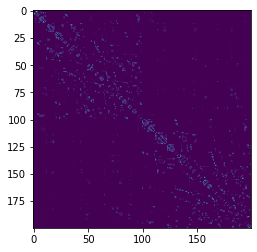

In [ ]:
plt.imshow(supports['train'][0][5])

In [ ]:
print("start training...", flush=True)

his_loss_train = []
his_loss_val =[]
val_time = []
train_time = []
min_loss = float('Inf')
grads = []

for i in range(epochs+1):

    train_loss = []
    train_acc = []
    train_f1 = []
    t1 = time.time()
    engine.set_state('train')

    x = input_dic['train']
    y = labels_dic['train']
    adj_idx = adj_mx_idx_dic['train']

    iter = 0
    # shuffle in-out-adj_idx
    x, y, adj_idx = shuffle(x, y, adj_idx)

    for batch_i in range(len(input_dic['train'])//batch_size):
        _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
        _x = torch.Tensor(x[batch_i * batch_size:
                            (batch_i + 1) * batch_size][...,None]).to(
                                device).transpose(1, 3)
        _x = scaler_x.transform(_x)
        _y = torch.tensor(y[batch_i * batch_size:
                            (batch_i + 1) * batch_size], dtype=torch.long,
                          device=device)

        if i > 0 and i % 30 == 0 and batch_i == 0:
            metrics = engine.train_classifier(_x, _y, None, {}, _adj_idx,
                                              lr_update=0.9)
        else:
            metrics = engine.train_classifier(_x, _y, None, {}, _adj_idx)

        train_loss.append(metrics[0])
        train_acc.append(metrics[1])
        train_f1.append(metrics[2])
        if iter % print_every == 0 :
            log = ('Iter: {:03d}, Train Loss: {:.6f},' +
                  'Train Acc: {:.4f}, Train F1: {:.4f}')
            print(log.format(iter, train_loss[-1], train_acc[-1], train_f1[-1]),
                  flush=True)
        iter += 1

    t2 = time.time()
    train_time.append(t2-t1)

    #validation
    valid_loss = []
    valid_acc = []
    valid_f1 = []

    s1 = time.time()
    engine.set_state('val')

    x = input_dic['val']
    y = labels_dic['val']
    adj_idx = adj_mx_idx_dic['val']


    for batch_i in range(len(input_dic['val'])//batch_size):
        _adj_idx = adj_idx[batch_i * batch_size:
                           (batch_i + 1) * batch_size]
        _x = torch.Tensor(x[batch_i * batch_size:
                            (batch_i + 1) * batch_size][...,None]).to(
                                device).transpose(1, 3)
        _y = torch.tensor(y[batch_i * batch_size:
                            (batch_i + 1) * batch_size], dtype=torch.long,
                          device=device)


        metrics = engine.eval_classifier(_x, _y, None, {}, _adj_idx)

        valid_loss.append(metrics[0])
        valid_acc.append(metrics[1])
        valid_f1.append(metrics[2])

    s2 = time.time()
    log = 'Epoch: {:03d}, Inference Time: {:.4f} secs'
    print(log.format(i,(s2-s1)))
    val_time.append(s2-s1)

    mtrain_loss = np.mean(train_loss)
    mtrain_acc = np.mean(train_acc)
    mtrain_f1 = np.mean(train_f1)

    mvalid_loss = np.mean(valid_loss)
    mvalid_acc = np.mean(valid_acc)
    mvalid_f1 = np.mean(valid_f1)

    his_loss_train.append((mtrain_loss, mtrain_acc, mtrain_f1))
    his_loss_val.append((mvalid_loss, mvalid_acc, mvalid_f1))

    log = ('Epoch: {:03d}, Train Loss: {:.6f}, Train Acc: {:.4f},' +
          'Train Weighted F1: {:.4f}, Valid Loss: {:.6f}, Valid Acc: {:.4f},' +
          'Valid Weighted F1: {:.4f}, Training Time: {:.4f}/epoch')
    print(log.format(i, mtrain_loss, mtrain_acc, mtrain_f1, mvalid_loss,
                     mvalid_acc, mvalid_f1, (t2 - t1)), flush=True)

    if mvalid_loss < min_loss:
        min_loss = mvalid_loss
        torch.save(engine.model.state_dict(), save_dir + save_ext + ".pth")

print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
print("Average Inference Time: {:.4f} secs".format(np.mean(val_time)))

plt.plot([i[0] for i in his_loss_train], label='train loss')
plt.plot([i[0] for i in his_loss_val], label='val loss')
plt.legend()
plt.show()

plt.plot([i[1] for i in his_loss_train], label='train acc')
plt.plot([i[1] for i in his_loss_val], label='val acc')
plt.legend()
plt.show()

plt.plot([i[2] for i in his_loss_train], label='train f1')
plt.plot([i[2] for i in his_loss_val], label='val f1')
plt.legend()
plt.show()

In [ ]:
plt.plot([i[0] for i in his_loss_train], label='train loss')
plt.plot([i[0] for i in his_loss_val], label='val loss')
plt.legend()
plt.show()

plt.plot([i[1] for i in his_loss_train], label='train acc')
plt.plot([i[1] for i in his_loss_val], label='val acc')
plt.legend()
plt.show()

plt.plot([i[2] for i in his_loss_train], label='train f1')
plt.plot([i[2] for i in his_loss_val], label='val f1')
plt.legend()
plt.show()

## 3. testing and visualizations

### loading pretrained models if any

In [ ]:
def load_trained_model(model_name, engine):
    pretrained_dict = torch.load(model_name)
    model_dict = engine.model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in
                       model_dict}
    model_dict.update(pretrained_dict)
    engine.model.load_state_dict(model_dict)

In [ ]:
load_trained_model(save_dir + save_ext + '.pth', engine)

### testing

In [ ]:
test_loss = []
test_acc = []
test_f1 = []
test_cm = []

engine.set_state('test')
x = input_dic['test']
y = labels_dic['test']
adj_idx = adj_mx_idx_dic['test']


for batch_i in tqdm(range(len(input_dic['test'])//batch_size)):
# for batch_i in tqdm(range(30)):
    _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
    _x = torch.Tensor(
        x[batch_i * batch_size: (batch_i + 1) * batch_size][...,None]
        ).to(device).transpose(1, 3)
    _y = torch.tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size],
                      dtype=torch.long, device=device)
    if batch_i == 0: # only viz the first one
        metrics = engine.eval_classifier(_x, _y, None, {}, _adj_idx, viz=False)
    else:
        metrics = engine.eval_classifier(_x, _y, None, {}, _adj_idx)

    test_loss.append(metrics[0])
    test_acc.append(metrics[1])
    test_f1.append(metrics[2])
    test_cm.append(metrics[3])

print('loss:', sum(test_loss)/len(test_loss),
      'acc:', sum(test_acc)/len(test_acc),
      'weighted f1:', sum(test_f1)/len(test_f1))

  0%|          | 0/177 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 177/177 [00:18<00:00,  9.55it/s]

loss: 0.36367362340546616 acc: 85.55813559322033 weighted f1: 90.85338983050843


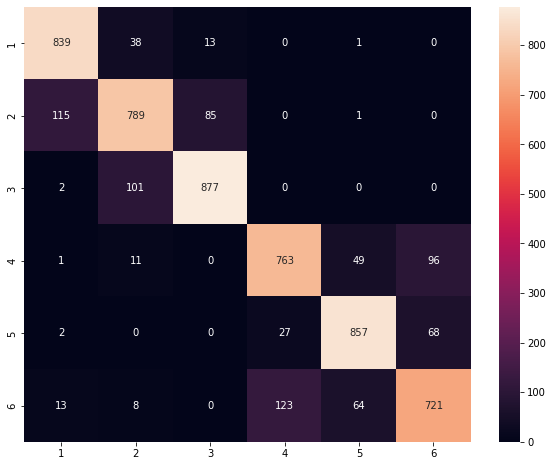

In [ ]:
import seaborn as sn
import pandas as pd
cm = np.stack(test_cm).sum(0)
df_cm = pd.DataFrame(cm, index=np.arange(6)+1,
                     columns=np.arange(6)+1)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, fmt='d')

### Intergrated Gradients

In [ ]:
# IG params
IG_save_dir = BASE_DIR + '/IG_pkl/strideTCN_4b2l_IG_ordered.pkl'
IG_batch_size = 2
load_saved_attr = True

if not load_saved_attr:
    ig_engine = trainer(scaler_x, in_dim, window_len_x,
                        input_dic['train'].shape[-1], nhid, dropout,
                        learning_rate, weight_decay, device, supports, True,
                        addaptadj, adjinit, kernel_size,
                        total_layers=total_layers, layers=block_layers,
                        batch_size=IG_batch_size, no_SC=no_SC, noT=False,
                        pool=True, use_corrcoef=False, out_class=out_class)
    load_trained_model(save_dir + save_ext + '.pth', ig_engine)

Run trained model loading cell if haven't done so: [here](#scrollTo=B6Pml_J3xtjj)

In [ ]:
if not load_saved_attr:
    ig_engine.set_state('test')
    x = input_dic['test']
    y = labels_dic['test']
    adj_idx = adj_mx_idx_dic['test']
    ig_supports = ig_engine.state_supports

    task_idx_dict = {}
    for i in range(len(y)):
        cur_y = y[i]
        if cur_y not in task_idx_dict:
            task_idx_dict[cur_y] = []
        task_idx_dict[cur_y].append(i)

    min_task_num = 1e5
    for k, v in task_idx_dict.items():
        print('task ', k, ':', len(v))
        min_task_num = min(min_task_num, len(v))
    print(min_task_num)

task  0 : 891
task  1 : 990
task  2 : 980
task  3 : 920
task  4 : 954
task  5 : 960
891


In [ ]:
if not load_saved_attr:
    from captum.attr import IntegratedGradients

    ig_engine.model.eval()
    ig = IntegratedGradients(ig_engine.model)

    task_signal_attrs = {}
    task_support_attrs = {}
    task_deltas = {}
    for agg_task in task_idx_dict:
        signal_attr = []
        support_attr = []
        delta = []
        print('task ', agg_task)
        target_class_index = [agg_task]*IG_batch_size

        for batch_i in tqdm(range(len(
            task_idx_dict[agg_task]) // IG_batch_size)):
            _x = torch.Tensor(x[task_idx_dict[agg_task]
                                [batch_i * IG_batch_size:
                                 (batch_i + 1) * IG_batch_size]][...,None]
                ).to(device).transpose(1, 3)
            _adj_idx = [adj_idx[i] for i in
                        task_idx_dict[agg_task][batch_i * IG_batch_size:
                                                (batch_i + 1) * IG_batch_size]]
            _s = [s[_adj_idx] for s in ig_supports]
            _s = torch.stack(_s, 1)
            # _x.requires_grad = True
            # _s.requires_grad = True

            attributions, d = ig.attribute((_x, _s), target=target_class_index,
                                           n_steps=30,
                                           return_convergence_delta=True)

            signal_attr.append(attributions[0].detach().cpu().numpy())
            support_attr.append(attributions[1].detach().cpu().numpy())
            delta.append(d.cpu().numpy())

        task_signal_attrs[agg_task] = np.concatenate(signal_attr,0).squeeze()
        task_support_attrs[agg_task] = np.concatenate(support_attr,0).squeeze()
        task_deltas[agg_task] = np.concatenate(delta)

    pkl_data = (task_support_attrs, task_signal_attrs, task_deltas)
    with open(IG_save_dir, 'wb') as f:
        pickle.dump(pkl_data, f, protocol=pickle.HIGHEST_PROTOCOL)

task  0


  0%|          | 0/445 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 445/445 [05:53<00:00,  1.26it/s]


task  1


100%|██████████| 445/445 [05:54<00:00,  1.26it/s]


task  2


100%|██████████| 445/445 [05:54<00:00,  1.25it/s]


task  3


100%|██████████| 445/445 [05:54<00:00,  1.25it/s]


task  4


100%|██████████| 445/445 [05:54<00:00,  1.25it/s]


task  5


100%|██████████| 445/445 [05:54<00:00,  1.25it/s]


#### Loading saved IG attributes

In [ ]:
if load_saved_attr:
    with open(IG_save_dir, 'rb') as f:
        task_support_attrs, task_signal_attrs, task_deltas = pickle.load(f)
        # # sort by task id
        # task_support_attrs = dict(sorted(task_support_attrs.items(),
        #                                  key=lambda x: x[0]))
        # task_signal_attrs = dict(sorted(task_signal_attrs.items(),
        #                                 key=lambda x: x[0]))

In [ ]:
print(map_17network_region)
print(map_17network_name)

#### ATTR_A

0


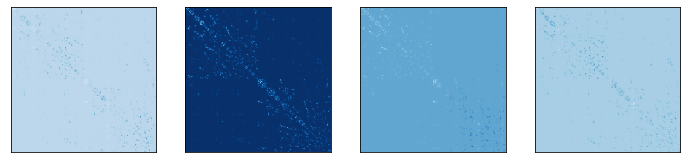

1


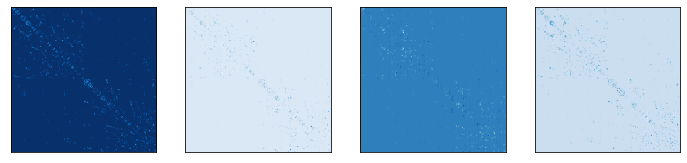

2


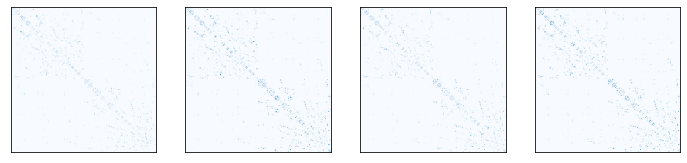

3


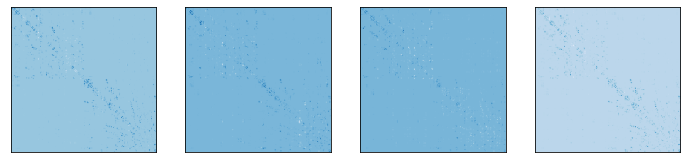

4


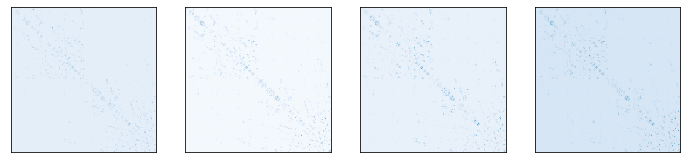

5


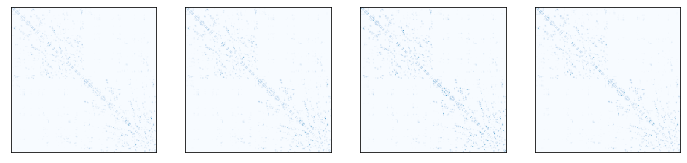

In [ ]:
# individual
for i in task_support_attrs:
    plot_individual_AttrA(task_id=i, num_sample=4)

In [ ]:
# invididual symmetry, and task col/row sum

'''check symmetry --> not nearly symmetric'''
# task_id = 1
# sample_id = 2
# cur_attr = task_support_attrs[task_id][sample_id]
# print(cur_attr.shape)
# print(cur_attr.min(), cur_attr.mean(), cur_attr.max())
# diff = cur_attr.transpose() - cur_attr
# print(diff.min(), diff.mean(), diff.max())

''' boxplots with AttrA'''
# row avg/sum
# task_bp_data, task_bp_data_no_rl = get_bp_data(task_support_attrs, mean_axis=-1)
# col avg / sum
task_bp_data, task_bp_data_no_rl = get_bp_data(task_support_attrs, mean_axis=1)
# task_bp_data, task_bp_data_no_rl = get_bp_data(
#     get_single_sess_attr(task_support_attrs, sess_idx=2), mean_axis=1)

In [ ]:
show_rank(task_bp_data_no_rl, keep_LR=False,)
        #   save_to_csv=BASE_DIR+'/rank_csv/A_region_rank_no_rl.csv')

In [ ]:
show_rank(task_bp_data, keep_LR=True,)
        #   save_to_csv=BASE_DIR+'/rank_csv/A_region_rank.csv')

task attr


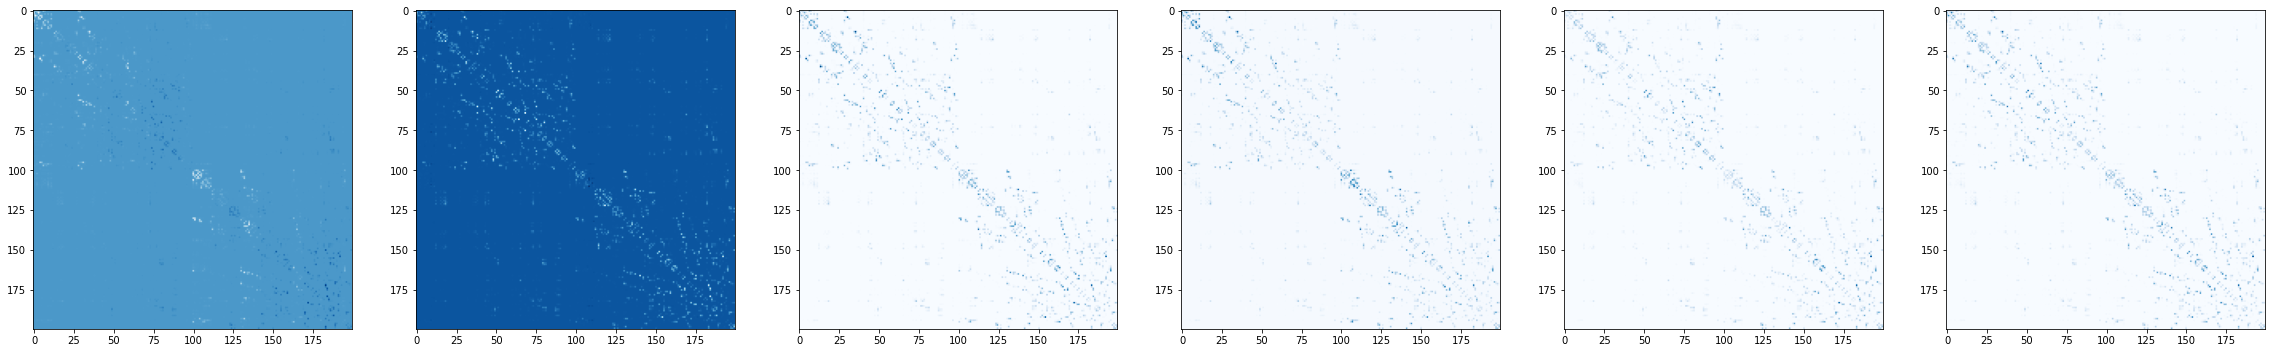

col avg of task attr means


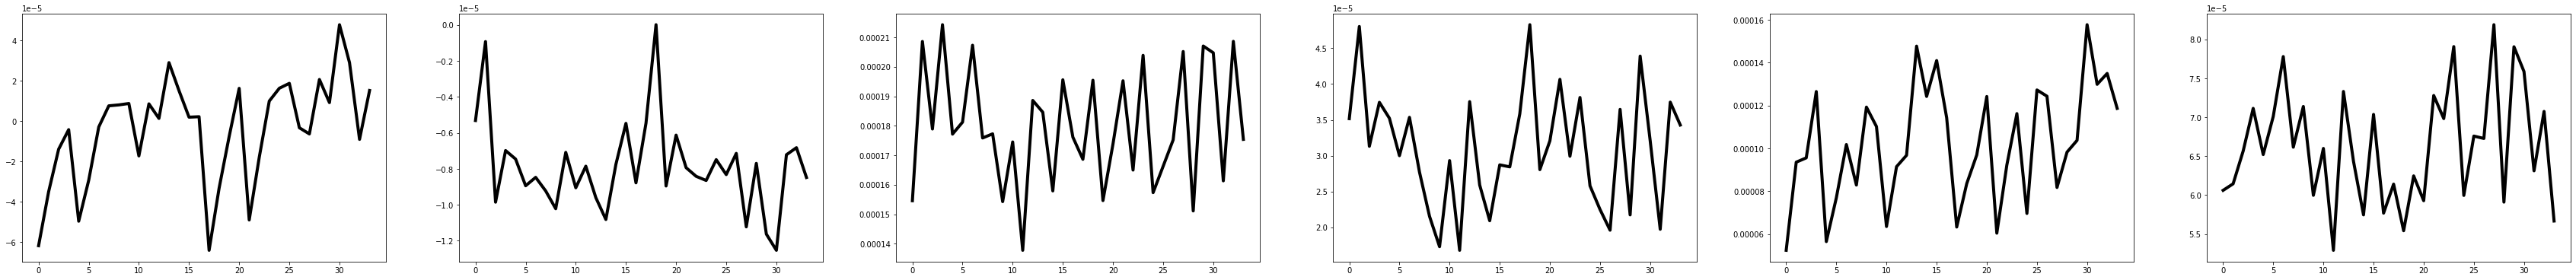

row avg of task attr means


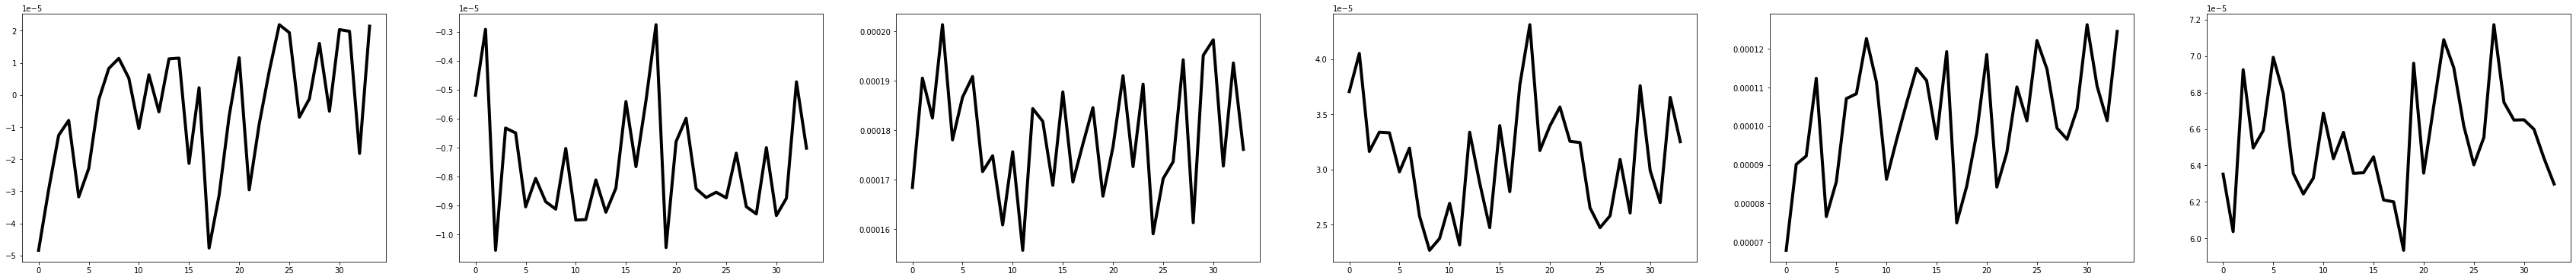

In [ ]:
plot_data = get_task_attr_mean(task_support_attrs, normalize=False)
print('task attr')
plot_sig(plot_data)
print('col avg of task attr means')
plot_sig(plot_data, figsize=(60, 6), mean_axis=0,
         subnet_map=map_17network_region)
print('row avg of task attr means')
plot_sig(plot_data, figsize=(60, 6), mean_axis=1,
         subnet_map=map_17network_region)

In [ ]:
'''compare attribution difference between two task attr means'''
compare_2tasks(target_task1=2, target_task2=1, use_normalized_attr=True)

#### ATTR_X

In [ ]:
"""all sessions"""
task_bp_data, task_bp_data_no_rl = get_bp_data(task_signal_attrs)
"""one session per task"""
# task_bp_data, task_bp_data_no_rl = get_bp_data(get_single_sess_attr(
                                    # task_signal_attrs, sess_idx=1))

In [ ]:
show_rank(task_bp_data_no_rl, keep_LR=False,#)
          save_to_csv=BASE_DIR+'/rank_csv/X_region_rank_no_rl.csv')

In [ ]:
show_rank(task_bp_data, keep_LR=True,#)
          save_to_csv=BASE_DIR+'/rank_csv/X_region_rank.csv')

#### <font color='red'>**Group Heterogeneity level for diff tasks**</font> --> using variance

From the result of the following cell: task 1 (VWM) & 2 (DYN) has very low heterogeneity compared with other tasks (but is this because of # sessions for 2&3 are fewer so the sliding window lengths are smaller??? --> no, checked with same window length, still similar)

In [ ]:
task_vars = []
for target_task in range(6):
    task_var = []
    for net_i in range(len(task_bp_data[target_task])):
        task_var.append(np.var(task_bp_data[target_task][net_i]))
    task_vars.append(sum(task_var) / len(task_var))
[i*1e8 for i in task_vars]

[19.900499717694693,
 3.361779142005727,
 3.955332525510535,
 40.44840623347643,
 44.01809321599277,
 15.956516935363075]

#### Signal's attributions

In [ ]:
'''signal's average attribution: it's for looking at the important brian regions
   seems regions around index 100 are important across tasks
'''
for k, v in task_signal_attrs.items():
    print(k, v.mean(0).shape)
    plt.imshow(v.mean(0))
    plt.show()

#### **Sanity check** signal attributions with translated signals

In [ ]:
x = input_dic['test']
y = labels_dic['test']
adj_idx = adj_mx_idx_dic['test']
x.shape

(5695, 256, 200)

In [ ]:
# task 3's sliding window length is 12, so translate it by 12*n and check diff
offset = 24
plt.imshow(x[297][offset:].transpose(1,0))
plt.show()
plt.imshow(x[0][:-offset].transpose(1,0))
plt.show()
print((x[297][offset:].transpose(1,0) - x[0][:-offset].transpose(1,0)).sum())
'''this example has a translation of 24'''

Use idx 0 & 297 to check.

In [ ]:
ig_engine.set_state('test')
x = input_dic['test']
y = labels_dic['test']
adj_idx = adj_mx_idx_dic['test']
ig_supports = ig_engine.state_supports

from captum.attr import IntegratedGradients

target_class_index = [3]*IG_batch_size
ig_engine.model.eval()
ig = IntegratedGradients(ig_engine.model)

signal_attr = []
delta = []
for batch_i in tqdm(range(149)):
    _x = torch.Tensor(x[batch_i * IG_batch_size: (batch_i + 1) * IG_batch_size][...,None]).to(device).transpose(1, 3)
    _adj_idx = adj_idx[batch_i * IG_batch_size: (batch_i + 1) * IG_batch_size]
    _s = [s[_adj_idx] for s in ig_supports]
    _s = torch.stack(_s, 1)

    attributions, d = ig.attribute((_x, _s), target=target_class_index, n_steps=30, return_convergence_delta=True)

    signal_attr.append(attributions[0].cpu().numpy())
    delta.append(d.cpu().numpy())

signal_attr = np.concatenate(signal_attr,0).squeeze()
delta = np.concatenate(delta)

100%|██████████| 87/87 [00:48<00:00,  1.79it/s]


-0.38489615391032184 0.34139510272635964


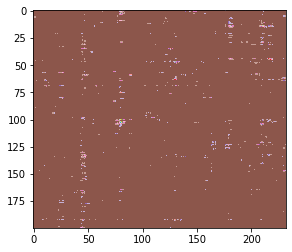

-0.3772313287111847 0.34853614363934565


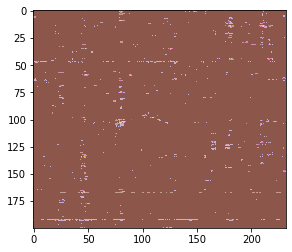

-0.2553231366873429 0.13845400714671555


In [ ]:
attr1 = signal_attr[297][:, offset:]
print(attr1.min(), attr1.max())
plt.imshow(attr1, cmap='tab20')
plt.show()

attr2 = signal_attr[0][:, :-offset]
print(attr2.min(), attr2.max())
plt.imshow(attr2, cmap='tab20')
plt.show()

print((attr1 - attr2).min(), (attr1 - attr2).max())

#### verifying if all-zero baseline works

In [ ]:
ig_engine.model.eval()
sc = []
for agg_task in task_idx_dict:
    print('task ', agg_task)
    target_class_index = [agg_task]*IG_batch_size

    # for batch_i in tqdm(range(len(task_idx_dict[agg_task]) // IG_batch_size)):
    for batch_i in tqdm(range(min_task_num // IG_batch_size)):
        _adj_idx = [adj_idx[i] for i in task_idx_dict[agg_task]
                    [batch_i * IG_batch_size: (batch_i + 1) * IG_batch_size]]
        _s = [s[_adj_idx] for s in ig_supports]
        _s = torch.stack(_s, 1)
        # ipdb.set_trace()
        sc.append(_s.squeeze().cpu().numpy())
sc = np.concatenate(sc, 0).mean(0)

task  3


100%|██████████| 445/445 [00:00<00:00, 2867.30it/s]


task  4


100%|██████████| 445/445 [00:00<00:00, 3165.35it/s]


task  5


100%|██████████| 445/445 [00:00<00:00, 3542.93it/s]


task  2


100%|██████████| 445/445 [00:00<00:00, 3583.21it/s]


task  0


100%|██████████| 445/445 [00:00<00:00, 3565.00it/s]


task  1


100%|██████████| 445/445 [00:00<00:00, 3669.15it/s]


In [ ]:
_x = torch.zeros((2, 1, 200, 256)).to(device)
_s = torch.zeros((2, 1, 200, 200)).to(device)
_s = torch.from_numpy(np.repeat(sc[None,None,...], 2, 0)).to(device)
ret = ig_engine.model(_x, _s)
print(ret)
print(torch.softmax(ret,1))

tensor([[-745427.8750, -437222.4688, 1734387.5000, -382362.9375,  411075.5000,
         -930959.6875],
        [-742644.3125, -435346.5312, 1729115.5000, -381271.3750,  408971.5625,
         -928201.4375]], device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([[0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)


### Pooling part viz

In [ ]:
for i in range(len(_S)):
    _S[i] = np.concatenate(_S[i])
    print(_S[i].shape)

(960, 100, 200, 64)
(960, 50, 200, 16)
(960, 17, 200, 4)
(960, 7, 200, 1)


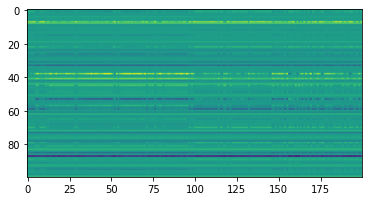

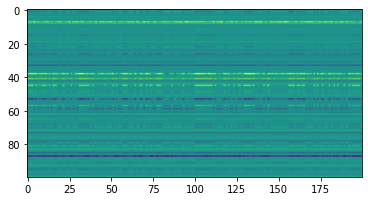

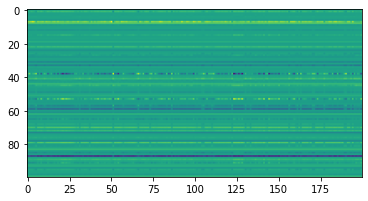

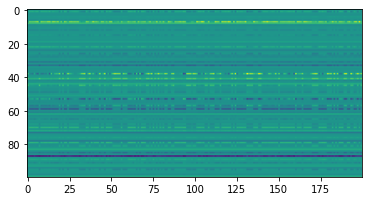

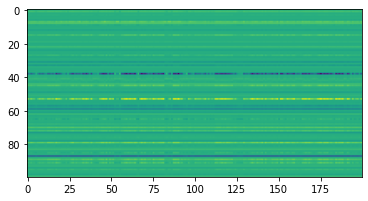

--------------


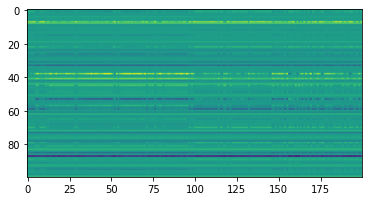

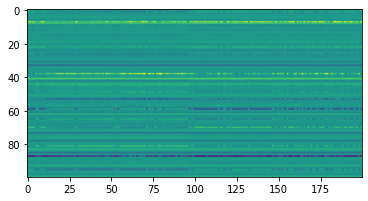

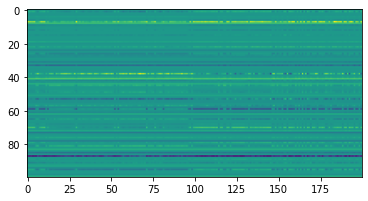

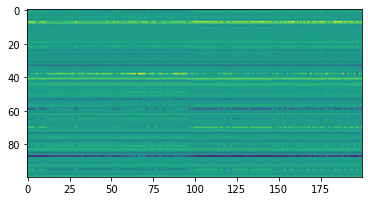

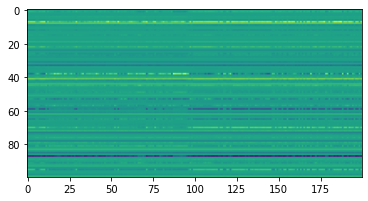

In [ ]:
for i in range(5):
    plt.imshow(_S[0][i,...,0])
    plt.show()

print('--------------')

for i in range(5):
    plt.imshow(_S[0][0,...,i])
    plt.show()

In [ ]:
del x, f_train, f_val, f_test, x_idxer, y, adj_idx
gc.collect()

### State transitions across time

In [ ]:
# k means cluster [i, :, :, t], aka cluster 200 length-100 vectors
from sklearn.cluster import KMeans

cross_t_assign = []
for i in range(5):
    for t in tqdm(range(64)):
        tmp = _S[0][i,...,t]
        tmp = tmp.transpose(1,0)
        tmp: (200, 100)
        kmeans = KMeans(n_clusters=7, random_state=0).fit(tmp)
        # print(kmeans.labels_)
        cross_t_assign.append(kmeans.labels_)
        # plt.plot(kmeans.labels_)
        # plt.show()
cross_t_assign = np.stack(cross_t_assign)
cross_t_assign.shape

100%|██████████| 64/64 [00:08<00:00,  7.69it/s]


(320, 200)

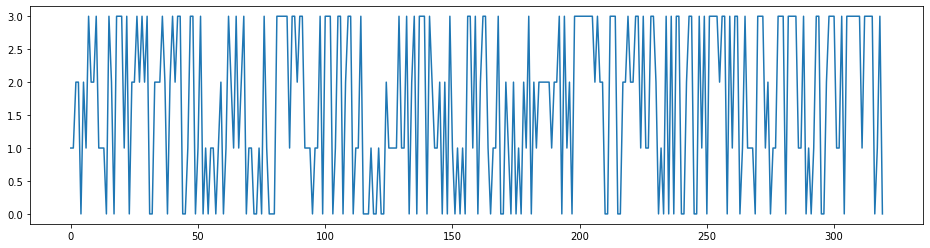

In [ ]:
k_across_t = 4
kmeans_across_t = KMeans(n_clusters=k_across_t, random_state=0
                         ).fit(cross_t_assign)
plt.figure(figsize=(16, 4))
plt.plot(kmeans_across_t.labels_)
plt.show()

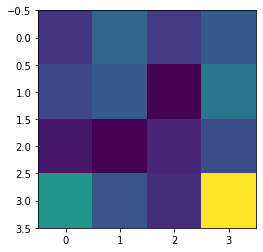

In [ ]:
# state transition probability (as a matrix)
transition_prob = np.zeros((k_across_t, k_across_t))
for i in range(len(kmeans_across_t.labels_) - 1):
    curr = kmeans_across_t.labels_[i]
    next = kmeans_across_t.labels_[i+1]
    transition_prob[curr, next] += 1

plt.imshow(transition_prob)
plt.show()

[[15. 23. 16. 21.]
 [18. 21.  8. 26.]
 [11.  8. 13. 19.]
 [32. 20. 14. 54.]]


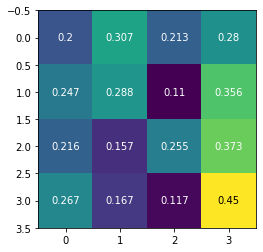

state 0 : 23.75 % of the time
state 1 : 22.8125 % of the time
state 2 : 15.9375 % of the time
state 3 : 37.5 % of the time


In [ ]:
# per row normalization: once in state x, how many prob to transit to state y
print(transition_prob)
row_norm_transition_prob = transition_prob / transition_prob.sum(1)[:, None]
plt.imshow(row_norm_transition_prob)
for i in range(k_across_t):
    for j in range(k_across_t):
        value = round(row_norm_transition_prob[i,j],3)
        if value > 0.4:
            col = 'black'
        else:
            col = 'w'
        plt.text(j, i, value, va='center', ha='center', color=col)
plt.show()

# statistics about each state
for i in range(k_across_t):
    print('state', i, ':', 100 * (kmeans_across_t.labels_ == i
                                  ).sum() / len(kmeans_across_t.labels_),
          '% of the time')

### Checking each state
how are the regions connected/co-activated in each state in the k_across_t states?

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in
                          locals().items()), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       x_idxer: 96.1 KiB
                             y: 47.3 KiB
                       adj_idx: 47.3 KiB
                    model_dict: 11.0 KiB
                           _19:  9.1 KiB
                           _20:  9.1 KiB
               pretrained_dict:  4.6 KiB
                          tqdm:  2.0 KiB
          gwnet_gat_classifier:  2.0 KiB
                           _i7:  1.8 KiB


### Adaptive adj viz

In [ ]:
x = input_dic['test']
y = labels_dic['test']
adj_idx = adj_mx_idx_dic['test']
engine.set_state('test')

task_idx_dict = {}
for i in range(len(y)):
    cur_y = y[i]
    if cur_y not in task_idx_dict:
        task_idx_dict[cur_y] = []
    task_idx_dict[cur_y].append(i)

In [ ]:
adp_tasks = {}

for agg_task in task_idx_dict:
    print('task ', agg_task)
    adp_tasks[agg_task] = []

    for batch_i in tqdm(range(len(task_idx_dict[agg_task]) // batch_size)):
        _adj_idx = [adj_idx[i] for i in
                    task_idx_dict[agg_task][batch_i * batch_size:
                                            (batch_i + 1) * batch_size]]
        _x = torch.Tensor(x[task_idx_dict[agg_task][batch_i * batch_size:
                                                    (batch_i + 1) * batch_size]]
                          [...,None]).to(device).transpose(1, 3)
        _y = torch.tensor([y[i] for i in
                           task_idx_dict[agg_task][batch_i * batch_size:
                                                   (batch_i + 1) * batch_size]],
                           dtype=torch.long, device=device)
        assert torch.all((_y == agg_task)) == True, _y
        engine.eval_classifier(_x, _y, None, {}, _adj_idx)
        adp_tasks[agg_task].append(engine.model.supports[:, 1].cpu().numpy())
    adp_tasks[agg_task] = np.concatenate(adp_tasks[agg_task])


task  0


100%|██████████| 55/55 [00:03<00:00, 15.12it/s]


task  1


100%|██████████| 61/61 [00:04<00:00, 15.21it/s]


task  2


100%|██████████| 61/61 [00:04<00:00, 15.19it/s]


task  3


100%|██████████| 57/57 [00:03<00:00, 15.19it/s]


task  4


100%|██████████| 59/59 [00:03<00:00, 15.18it/s]


task  5


100%|██████████| 60/60 [00:03<00:00, 15.18it/s]


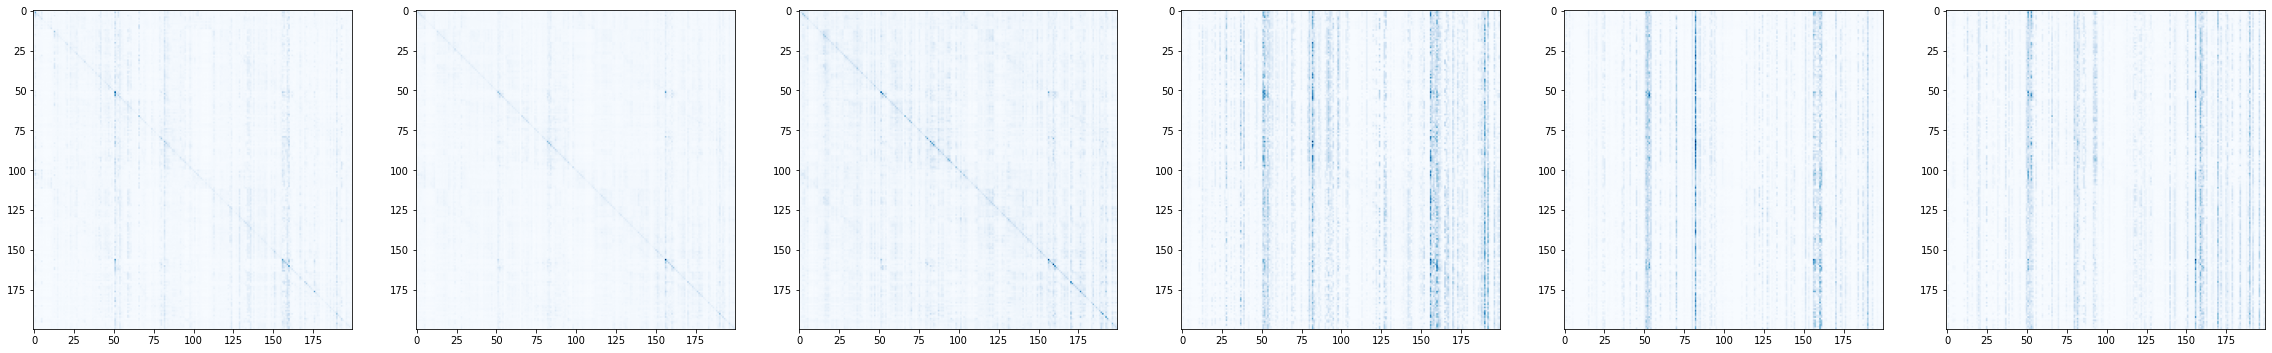

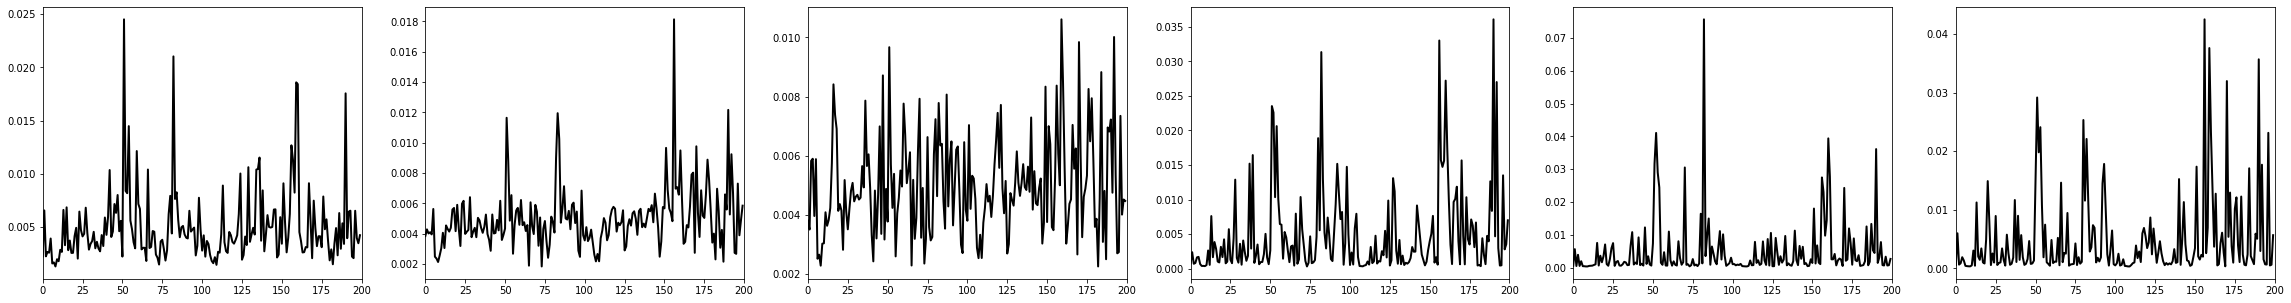

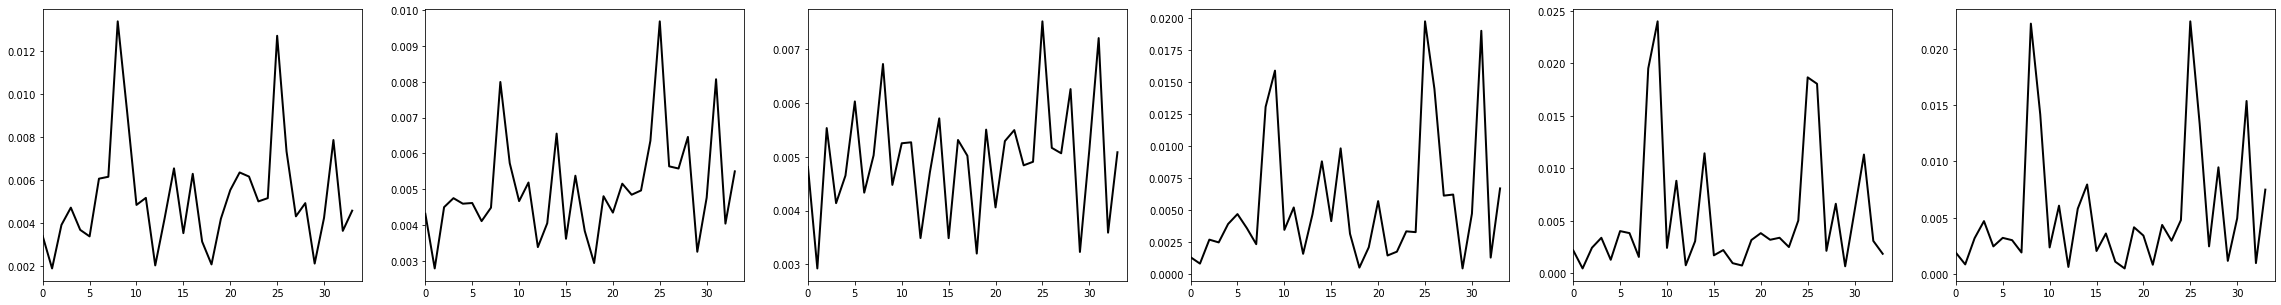

In [ ]:
rows = 1
cols = 6
linewidth = 2

# task average
axes=[]
fig=plt.figure(figsize=(40, 8))
for target_task in range(rows*cols):
    ax = fig.add_subplot(rows, cols, target_task+1)
    axes.append(ax)
    plt.imshow(adp_tasks[target_task].mean(0), cmap='Blues')
plt.show()

# task average column sum, 200 ROIs
axes=[]
fig=plt.figure(figsize=(40,5))
for target_task in range(rows*cols):
    ax = fig.add_subplot(rows, cols, target_task+1)
    axes.append(ax)
    plt.plot(adp_tasks[target_task].mean(0).mean(0), 'k', linewidth=linewidth)
    ax.set_xlim([0, 200])
plt.show()

# task average column sum, 17-34 networks
subnet_val_tasks = {}
axes=[]
fig=plt.figure(figsize=(40,5))
for target_task in range(rows*cols):
    ax = fig.add_subplot(rows, cols, target_task+1)
    axes.append(ax)
    ROI_sum = adp_tasks[target_task].mean(0).mean(0)
    subnet_val = []
    for v in sorted(map_17network_region.items()):
        # ipdb.set_trace()
        subnet_val.append(ROI_sum[v[1]].mean())
    subnet_val_tasks[target_task] = subnet_val
    plt.plot(subnet_val, 'k', linewidth=linewidth)
    plt.plot()
    ax.set_xlim([0, 34])
plt.show()

task  0


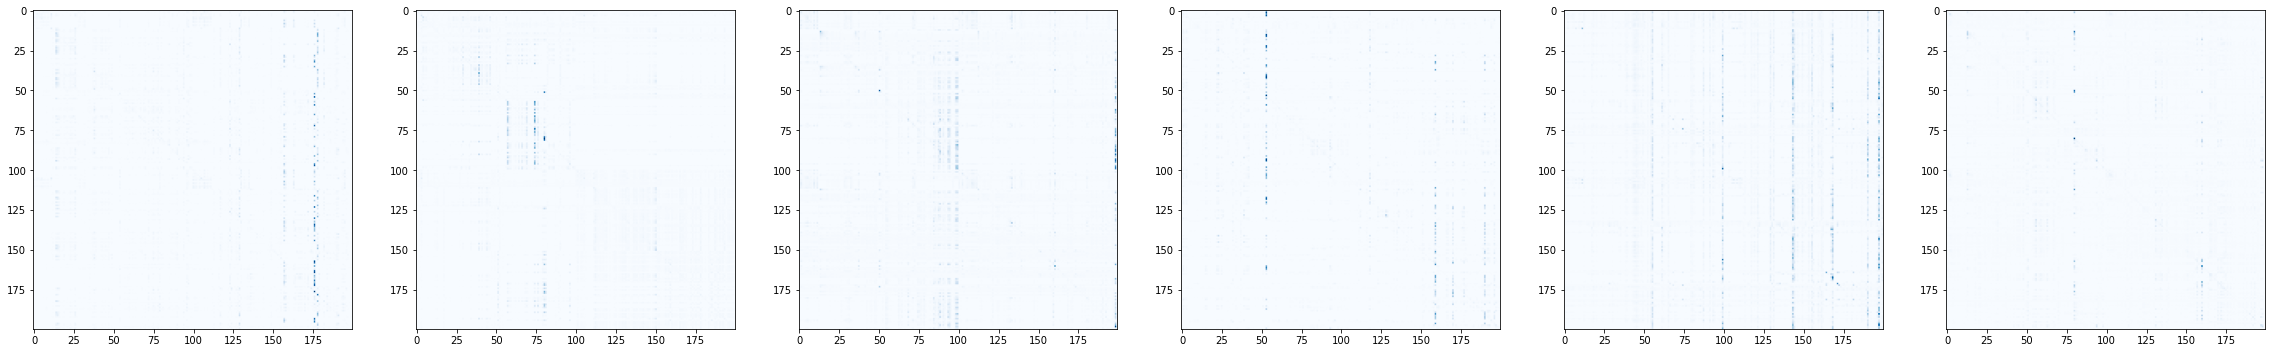

task  1


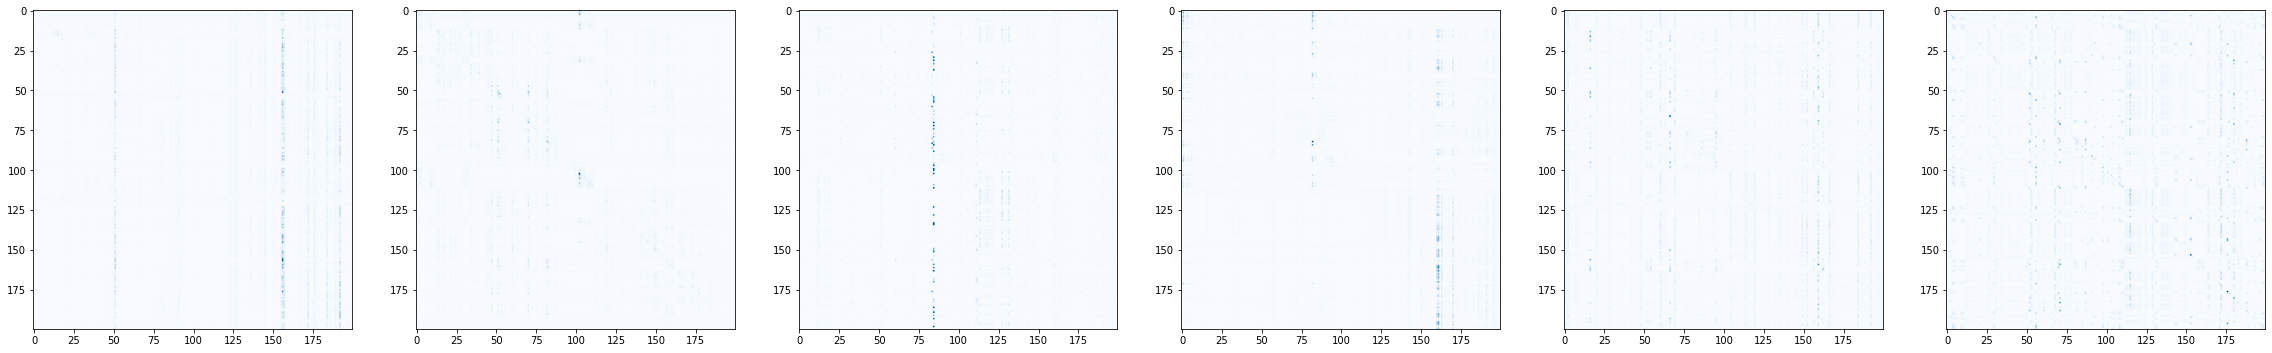

task  2


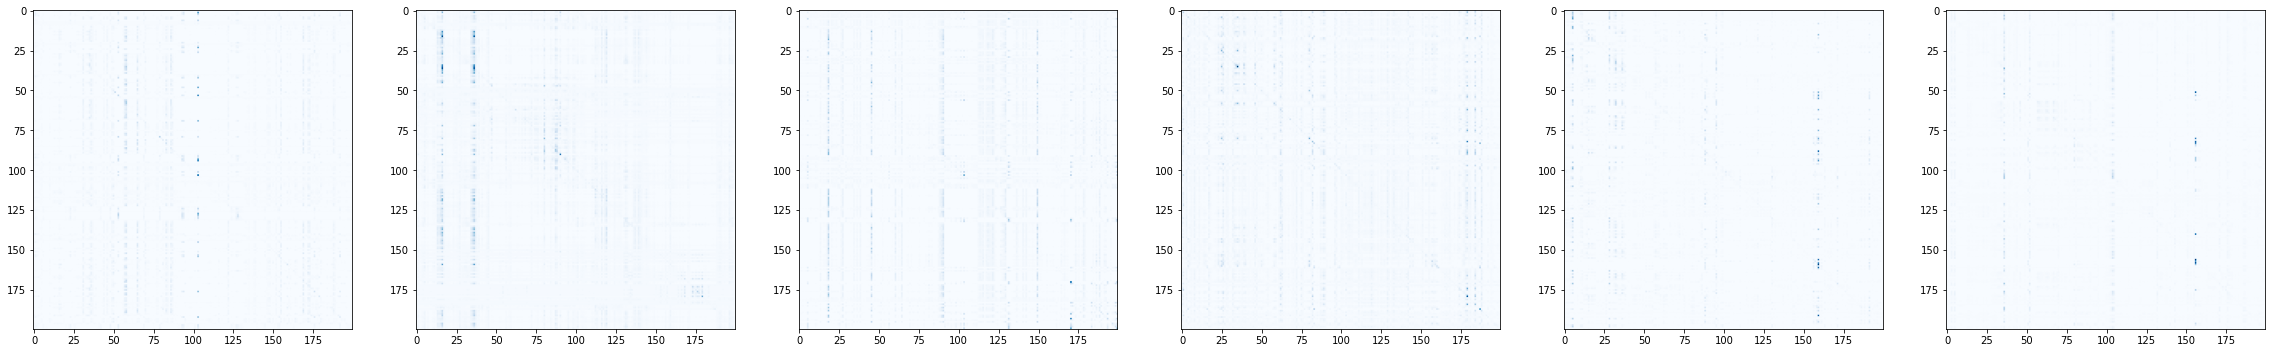

task  3


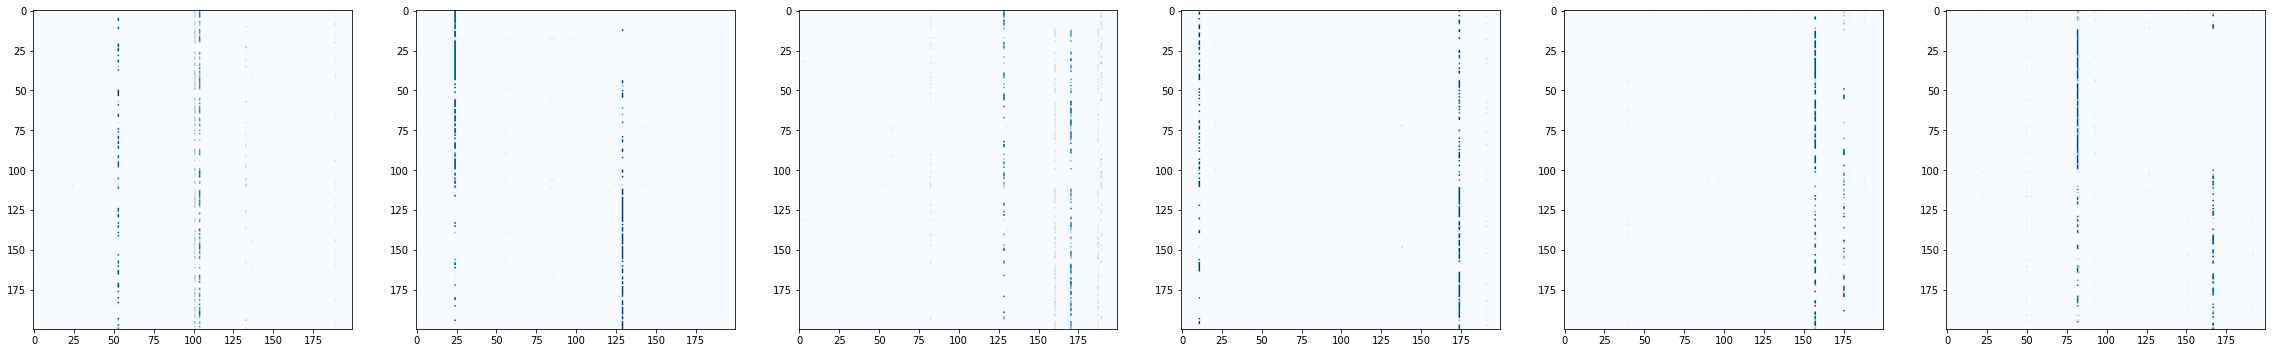

task  4


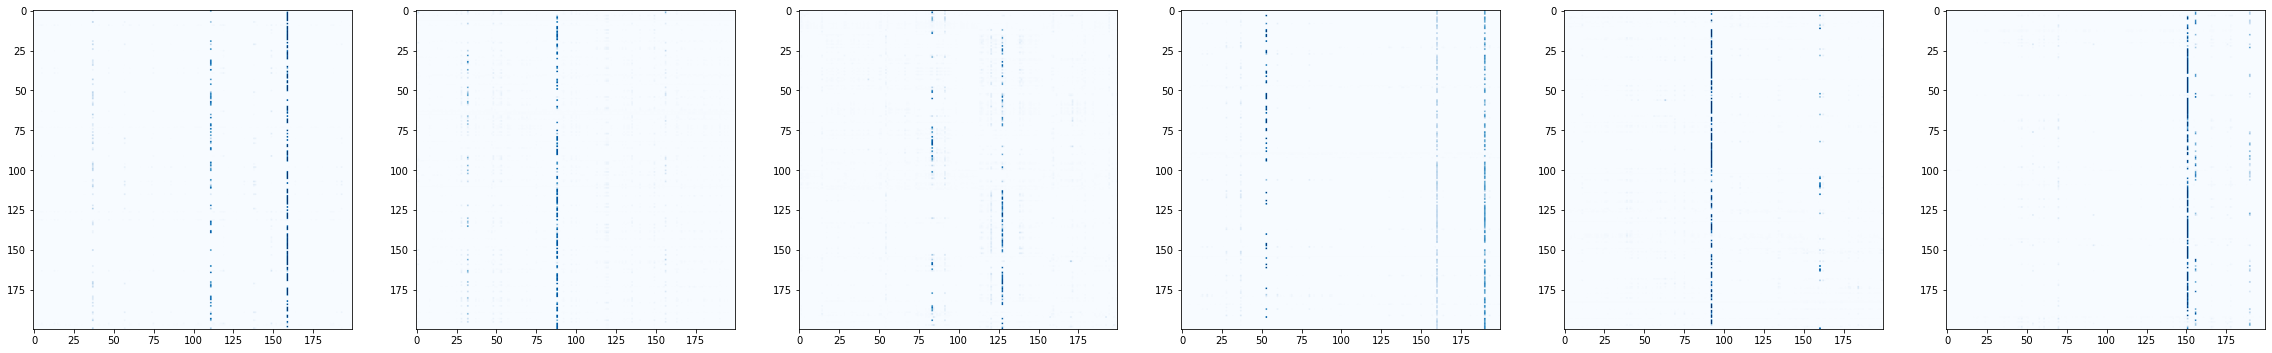

task  5


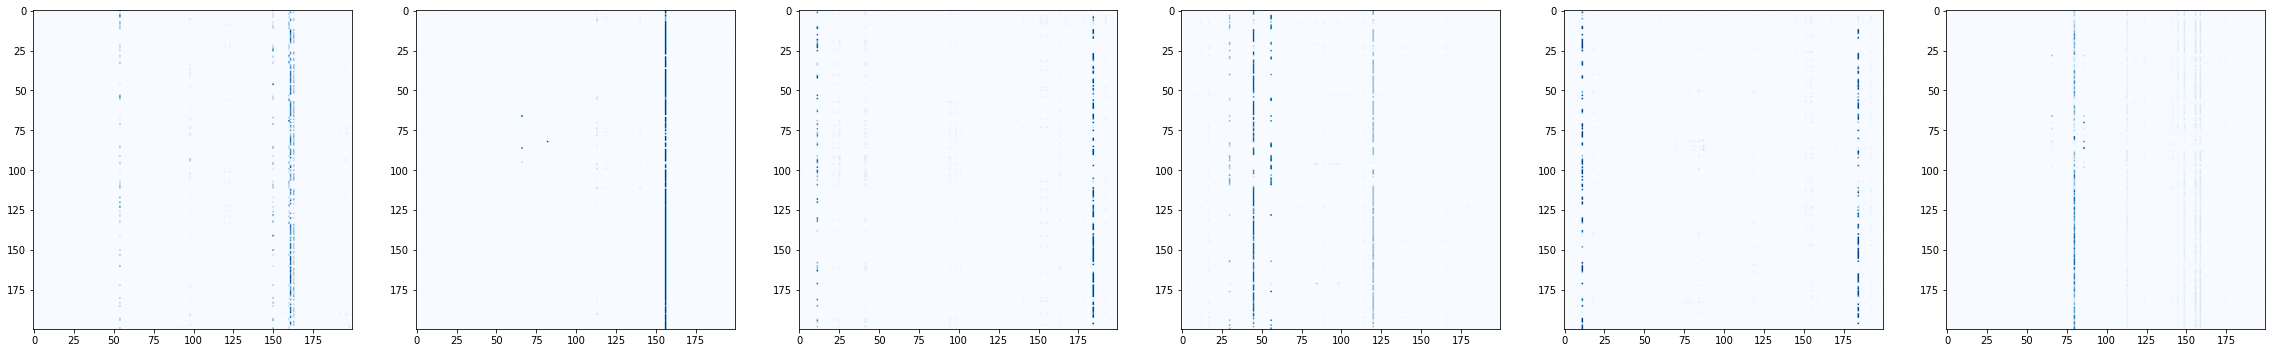

In [ ]:
# checking individual samples --> indeed different
rows = 1
cols = 6 # how many samples to visualize
figsize = (40, 8)
sample_id_max = 800

for target_task in adp_tasks:
    print('task ', target_task)
    plot_id = sample(range(sample_id_max), cols)
    # plot_id = np.arange(cols)
    axes=[]
    fig=plt.figure(figsize=figsize)
    for idx in range(rows*cols):
        ax = fig.add_subplot(rows, cols, idx+1)
        axes.append(ax)
        plt.imshow(adp_tasks[target_task][plot_id[idx]], cmap='Blues')
    plt.show()

In [ ]:
show_rank(subnet_val_tasks)
# mainly giving limbicB_OFC and DefaultB more weights???

### Adaptive adj viz 2

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.patches as mpatches

input_dic.keys()

dict_keys(['test'])

In [ ]:
key = 'test' # 'test'
x = input_dic[key]
y = labels_dic[key]
adj_idx = adj_mx_idx_dic[key]
engine.set_state(key)

task_idx_dict = {}
for i in range(len(y)):
    cur_y = y[i]
    if cur_y not in task_idx_dict:
        task_idx_dict[cur_y] = []
    task_idx_dict[cur_y].append(i)

In [ ]:
adp_tasks = {}
nodevec_tasks = {}
adp_dim = 0 if no_SC else 1

# for agg_task in task_idx_dict:
for agg_task in range(6):
    print('task ', agg_task)
    nodevec_tasks[agg_task] = []
    adp_tasks[agg_task] = []

    for batch_i in tqdm(range(len(task_idx_dict[agg_task]) // batch_size)):
        _adj_idx = [adj_idx[i] for i in
                    task_idx_dict[agg_task][batch_i * batch_size:
                                            (batch_i + 1) * batch_size]]
        _x = torch.Tensor(x[task_idx_dict[agg_task][batch_i * batch_size:
                                                    (batch_i + 1) * batch_size]]
                          [...,None]).to(device).transpose(1, 3)
        # _y = torch.tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size],
        #                 dtype=torch.long, device=device)
        _y = torch.tensor([y[i] for i in
                           task_idx_dict[agg_task][batch_i * batch_size:
                                                   (batch_i + 1) * batch_size]],
                           dtype=torch.long, device=device)
        assert torch.all((_y == agg_task)) == True, _y

        engine.eval_classifier(_x, _y, None, {}, _adj_idx)
        nodevec_tasks[agg_task].append(torch.einsum('ncl,lv->ncv', (_x[:,0,...], engine.model.nodevec)).detach().cpu().numpy())
        adp_tasks[agg_task].append(engine.model.supports[:, adp_dim].cpu().numpy())

    # last (incomplete) batch
    batch_i += 1
    _adj_idx = [adj_idx[i] for i in
                task_idx_dict[agg_task][batch_i * batch_size:]]
    _x = torch.Tensor(x[task_idx_dict[agg_task][batch_i * batch_size:]]
                        [...,None]).to(device).transpose(1, 3)
    # _y = torch.tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size],
    #                 dtype=torch.long, device=device)
    _y = torch.tensor([y[i] for i in
                        task_idx_dict[agg_task][batch_i * batch_size:]],
                        dtype=torch.long, device=device)
    assert torch.all((_y == agg_task)) == True, _y

    engine.eval_classifier(_x, _y, None, {}, _adj_idx)
    nodevec_tasks[agg_task].append(torch.einsum('ncl,lv->ncv', (_x[:,0,...], engine.model.nodevec)).detach().cpu().numpy())
    adp_tasks[agg_task].append(engine.model.supports[:, adp_dim].cpu().numpy())

    nodevec_tasks[agg_task] = np.concatenate(nodevec_tasks[agg_task])
    adp_tasks[agg_task] = np.concatenate(adp_tasks[agg_task])


task  0


100%|███████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.45it/s]


task  1


100%|███████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 20.35it/s]


task  2


100%|███████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.59it/s]


task  3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 20.51it/s]


task  4


100%|███████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.63it/s]


task  5


100%|███████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 20.88it/s]


In [ ]:
# separating subjects
num_subj = len(select_id)
subj_nodevec_tasks = []
for i in range(num_subj):
    subj_nodevec_tasks.append({})

for k, v in nodevec_tasks.items():
    sample_per_subj = round(len(v) / num_subj)
    for i in range(num_subj):
        subj_nodevec_tasks[i][k] = v[sample_per_subj*i : sample_per_subj*(i+1)]

# subj_nodevec_tasks[subj_id][task_id]

In [ ]:
PLT_TASKS = ['rest', 'VWM', 'DYN', 'DOT', 'MOD', 'PVT']
def tsne_scatter(x, colors, plt_tasks=PLT_TASKS):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)], label=colors)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add color legend
    assert len(palette) == len(plt_tasks)
    pops = []
    for i in range(len(plt_tasks)):
        pops.append(mpatches.Patch(color=palette[i], label=plt_tasks[i]))
    plt.legend(handles=pops)

    # # add the labels for each digit corresponding to the label
    # txts = []

    # for i in range(num_classes):

    #     # Position of each label at median of data points.

    #     xtext, ytext = np.median(x[colors == i, :], axis=0)
    #     txt = ax.text(xtext, ytext, str(i), fontsize=24)
    #     txt.set_path_effects([
    #         PathEffects.Stroke(linewidth=5, foreground="w"),
    #         PathEffects.Normal()])
    #     txts.append(txt)

    return f, ax, sc#, txts

In [ ]:
## single task, interpolating through the latent vector between subj0 & subj 1

task_id = 5
# subj_id = [0, 1] # 0-5 all correct
# subj_id = [1, 2] # 0-5 all correct
subj_id = [0, 2] # 0-5 all correct
viz_node = 1

num_sample = subj_nodevec_tasks[0][task_id].shape[0]
print(f'number of samples: {num_sample}')

min_d = np.inf
max_d = 0
pos_min = None
pos_max = None
for i in range(num_sample):
    for j in range(i + 1, num_sample):
        # ipdb.set_trace()
        cur_d = np.linalg.norm(subj_nodevec_tasks[subj_id[0]][task_id][i] - subj_nodevec_tasks[subj_id[1]][task_id][j])
        if cur_d < min_d:
            min_d = cur_d
            pos_min = (i, j)
        if cur_d > max_d:
            max_d = cur_d
            pos_max = (i, j)
print('position and min distance:', pos_min, min_d)
print('position and max distance:', pos_max, max_d)

# pos = pos_max
pos = pos_min

'''test if the model classifies the selected samples correctly'''
engine = trainer(scaler_x, in_dim, window_len_x, input_dic['test'].shape[-1], nhid,
                 dropout, learning_rate, weight_decay, device,
                 supports, gcn_bool, addaptadj, adjinit, kernel_size,
                 total_layers=total_layers, layers=block_layers,
                 out_nodes=input_dic['test'].shape[-1], F_t=1,
                 subsample=False, F_only=True, batch_size=2,
                 use_z=True, noT=False, pool=True, use_corrcoef=False,
                 classify=True, verbose=False, no_SC=no_SC)
load_trained_model(savedir+save_ext+'.pth', engine)
engine.set_state('test')
engine.model.eval()

ids = [p + len(task_idx_dict[task_id]) // 3 * s_i for p, s_i in zip(pos, subj_id)]
print('ids:', ids)

for id in ids:
    _adj_idx = adj_idx[task_idx_dict[task_id][id]]
    _x = torch.Tensor(x[task_idx_dict[task_id][id]][None,...,None]).to(device).transpose(1, 3)
    _y = torch.tensor([y[i] for i in [task_idx_dict[task_id][id]]],
                      dtype=torch.long, device=device)
    assert torch.all((_y == task_id)) == True, _y

    support = None if no_SC else engine.state_supports[0][_adj_idx][None,None,...]
    support = None if no_SC else torch.cat((support, support))
    with torch.no_grad():
        y_pred = torch.argmax(F.softmax(engine.model(torch.cat((_x, _x)),
                                                     support)[0], 0)).item()
    assert y_pred == task_id, f'wrong prediction from model, true class {task_id}, pred {y_pred}'

'''test if the model classifies the selected samples reconstructed from the latent vector correctly
   Spoiler alert: No.'''

Theta = engine.model.nodevec.detach().cpu().numpy()

def _run_model(cur_emb, recovered, msg='pred from recovered signal'):
    ''' cur_emb: use to generate support
        recovered: input signal
    '''
    if no_SC:
        fake_s = None
    else:
        cur_emb = torch.Tensor(cur_emb).to(device)[None,...]
        fake_s = F.softmax(F.relu(torch.matmul(cur_emb, cur_emb.transpose(1,2))), dim=2)
        fake_s = torch.stack((fake_s, fake_s))

    recovered = torch.Tensor(recovered[None, None, ...]).to(device)
    with torch.no_grad():
        pred_rec = torch.argmax(F.softmax(engine.model(
            torch.cat((recovered, recovered)), fake_s)[0], 0)).item()
    print(msg, pred_rec)

for s_i, p_i, id in zip(subj_id, pos, ids):
    cur_emb = subj_nodevec_tasks[s_i][task_id][p_i]
    recovered = np.matmul(cur_emb, np.linalg.pinv(Theta))
    gt = x[task_idx_dict[task_id][id]].transpose(1, 0)
    print(recovered.shape, gt.shape)

    plt.plot(recovered[viz_node], label='recovered')
    plt.plot(gt[viz_node], label='gt')
    plt.legend()
    plt.show()

    _run_model(cur_emb, recovered)


'''interpolation through latent node averaging'''
avg_pt = (subj_nodevec_tasks[subj_id[0]][task_id][pos[0]] + subj_nodevec_tasks[subj_id[1]][task_id][pos[1]]) * 0.5
avg_rec = np.matmul(avg_pt, np.linalg.pinv(Theta))
_run_model(avg_pt, avg_rec, 'pred from averaged signal recovered from theta')


'''interpolation through signal averaging (but aligned)'''
# task_ids = [0,1]
# for s_i, p_i, id, task_id in zip(subj_id, pos, ids, task_ids):
for s_i, p_i, id in zip(subj_id, pos, ids):
    cur_emb = subj_nodevec_tasks[s_i][task_id][p_i]
    gt = x[task_idx_dict[task_id][id]].transpose(1, 0)
    msg = 'pred from signal'
    msg += '' if no_SC else ' but fake supports'
    _run_model(cur_emb, gt, msg)


sig1 = x[task_idx_dict[task_id][ids[0]]] # x[task_idx_dict[task_ids[0]][ids[0]]]
sig2 = x[task_idx_dict[task_id][ids[1]]] # x[task_idx_dict[task_ids[1]][ids[1]]]
avg_sig = 0.5 * (sig1 + sig2).transpose(1, 0)
_run_model(avg_pt, avg_sig, 'pred from averaged signal')

# plot averaged signals together with its sources
plt.plot(sig1[:, viz_node], label='sig1')
plt.plot(sig2[:, viz_node], label='sig2')
plt.plot(avg_sig[viz_node], label='avg sig')
plt.legend()
plt.show()

# # double check the distance between averaged signal's emb to its sources
# avg_sig_emb = np.matmul(avg_sig, Theta)
# emb1 = subj_nodevec_tasks[subj_id[0]][task_id][pos[0]]
# emb2 = subj_nodevec_tasks[subj_id[1]][task_id][pos[1]]
# print(f'dist to sig1: {np.linalg.norm(avg_sig_emb - emb1)},',
#       f'dist to sig2: {np.linalg.norm(avg_sig_emb - emb2)},',
#       f'..and in case! sig1 sig2 distance is {np.linalg.norm(emb1 - emb2)}')
'''But of course... it's just a linear projection... X_avg*Theta will be just X1*Theta/2 + X2*Theta/2 ...'''

(2, 231, 5)
(462, 5)
(462,)


/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 1.1732680797576904 seconds


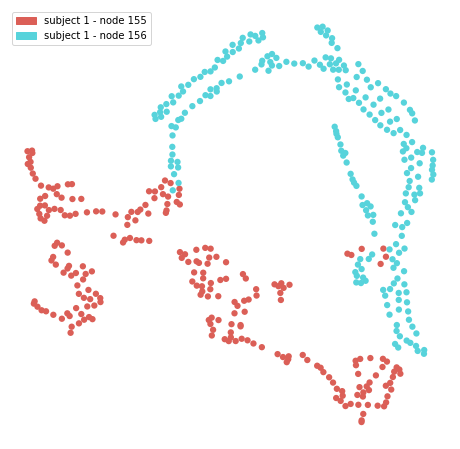

(2, 231, 5)
(462, 5)
(462,)


/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 1.086775302886963 seconds


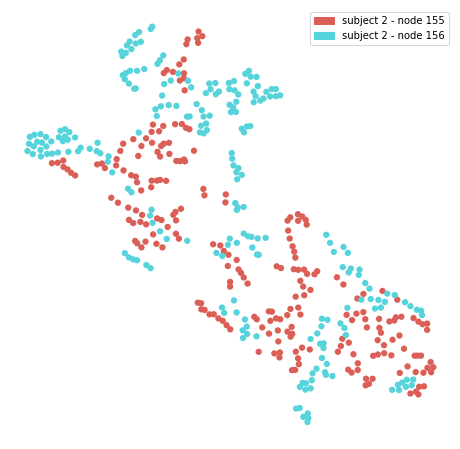

(2, 231, 5)
(462, 5)
(462,)


/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 1.0718555450439453 seconds


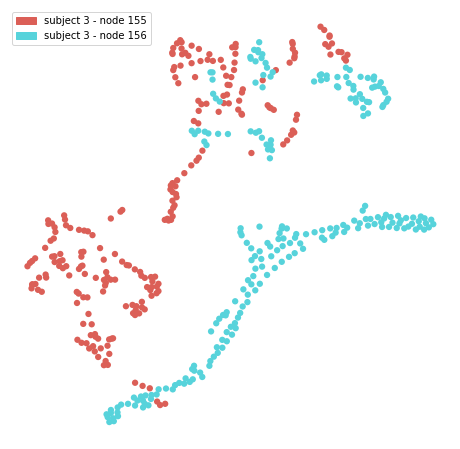

/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 2.681940793991089 seconds


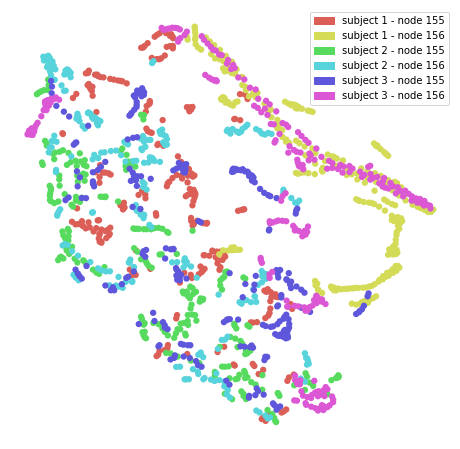

In [ ]:
# single task, different graph nodes

i = 0 # task id
# [start_node, end_node)
start_node = 155
end_node = 157

x_sets = []
y_sets = []
legends = []

tmp = subj_nodevec_tasks#[1:2]
for subj_id in range(len(tmp)):
    cur_vec = tmp[subj_id][i][:, start_node:end_node]

    cur_vec = cur_vec.transpose(1, 0, 2)
    num_nodes, num_sample, num_dim = cur_vec.shape
    print(cur_vec.shape)
    x_set = cur_vec.reshape(-1, num_dim)
    print(x_set.shape)
    assert (x_set[: num_sample] == cur_vec[0]).all()

    y_set = np.repeat(np.arange(num_nodes), num_sample)
    print(y_set.shape)

    legend = [f'subject {subj_id+1} - node {i}' for i in np.arange(start_node, end_node)]

    x_sets.append(x_set)
    y_sets.append(y_set + num_nodes * subj_id)
    # ipdb.set_trace()
    legends += legend

    time_start = time.time()
    cur_tsne = TSNE(random_state=rand_seed).fit_transform(x_set)
    print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds')

    tsne_scatter(cur_tsne, y_set, legend)
    plt.show()

# ipdb.set_trace()
x_sets = np.concatenate(x_sets)
y_sets = np.concatenate(y_sets)
time_start = time.time()
cur_tsne = TSNE(random_state=rand_seed).fit_transform(x_sets)
print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds')

tsne_scatter(cur_tsne, y_sets, legends)
plt.show()

(231, 200, 5)
(300, 200, 5)
(280, 200, 5)
(276, 200, 5)
(371, 200, 5)
(240, 200, 5)


/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sikun/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 3.4347991943359375 seconds


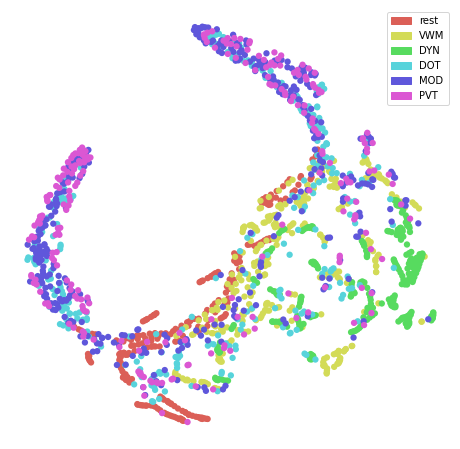

In [ ]:
# multiple tasks, single node

# node_i = 156
# for subj_id in range(3):

subj_id = 0
for node_i in range(156,157):
    tmp = subj_nodevec_tasks[subj_id]
    x_set = []
    y_set = []
    ctr = 0
    for i in list(tmp.keys())[0:]:
        cur_vec = tmp[i]
        num_sample, num_nodes, num_dim = cur_vec.shape
        print(cur_vec.shape)
        x_set.append(cur_vec[:, node_i])

        y_set.append(np.repeat(ctr, num_sample))
        ctr += 1

    x_set = np.concatenate(x_set)
    y_set = np.concatenate(y_set)

    time_start = time.time()
    cur_tsne = TSNE(random_state=rand_seed).fit_transform(x_set)
    print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds')

    tsne_scatter(cur_tsne, y_set, PLT_TASKS[0:])
    plt.show()

rest & VWM very similar, DYN are somewhat similar to them but a bit different. DOT, MOD, PVT very similar.

(224, 200, 5)
(299, 200, 5)
(277, 200, 5)
PCA done! Time elapsed: 0.15938019752502441 seconds
Variance explained per principal component: [0.83035845 0.09759357 0.03677849 0.02109576 0.01417375], sum: 1.0


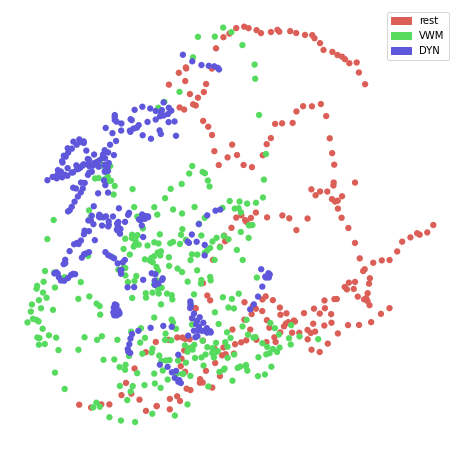

(224, 200, 5)
(299, 200, 5)
(277, 200, 5)
PCA done! Time elapsed: 0.0018811225891113281 seconds
Variance explained per principal component: [0.7624164  0.1120808  0.05642441 0.03652766 0.03255064], sum: 0.9999999403953552


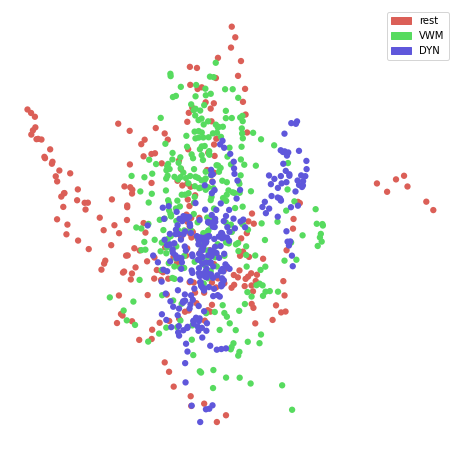

(224, 200, 5)
(298, 200, 5)
(277, 200, 5)
PCA done! Time elapsed: 0.0015227794647216797 seconds
Variance explained per principal component: [0.76091325 0.11373028 0.05392826 0.04822634 0.02320175], sum: 0.9999999403953552


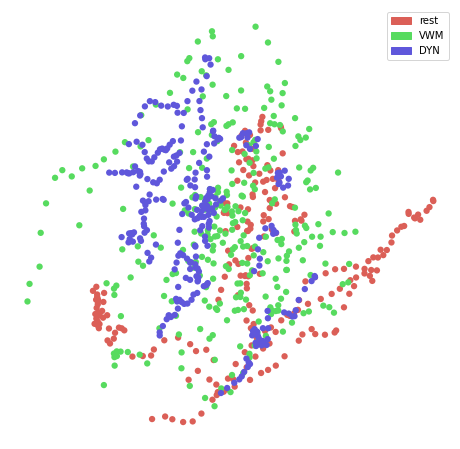

In [ ]:
# multiple tasks, single node

node_i = 156

for subj_id in range(3):
    tmp = subj_nodevec_tasks[subj_id]
    x_set = []
    y_set = []
    ctr = 0
    for i in list(tmp.keys())[:3]:
        cur_vec = tmp[i]
        num_sample, num_nodes, num_dim = cur_vec.shape
        print(cur_vec.shape)
        x_set.append(cur_vec[:, node_i])

        y_set.append(np.repeat(ctr, num_sample))
        ctr += 1

    x_set = np.concatenate(x_set)
    y_set = np.concatenate(y_set)

    time_start = time.time()
    pca = PCA(n_components=5)
    pca_result = pca.fit_transform(x_set)
    print(f'PCA done! Time elapsed: {time.time()-time_start} seconds')
    print(f'Variance explained per principal component: {pca.explained_variance_ratio_}, sum: {pca.explained_variance_ratio_.sum()}')

    pca_df = pd.DataFrame(columns=[f'pca{i}' for i in range(5)])
    for i in range(5):
        pca_df[f'pca{i + 1}'] = pca_result[:, i]

    two_comp = pca_df[['pca1','pca2']]
    tsne_scatter(two_comp.values, y_set, PLT_TASKS[:3])
    plt.show()